# Identifiability Analysis
In this tutorial, we take you through performing identifiability analysis using the custom `ProfileLikelihoodAnalysis` module, also included in the files. We start by recreating the system from the previous tutorial.

In [1]:
using DifferentialEquations, Plots, Random
using Optimization, SciMLSensitivity, Zygote, OptimizationOptimJL, LineSearches
using ProfileLikelihoodAnalysis, Measurements

[ Info: Precompiling ProfileLikelihoodAnalysis [39511702-9eb0-46d7-85ca-8fe9f617d6f2]


We define the ordinary differential equations, and set the parameters to a rough approximation of the found parameters in the parameter estimation notebook.

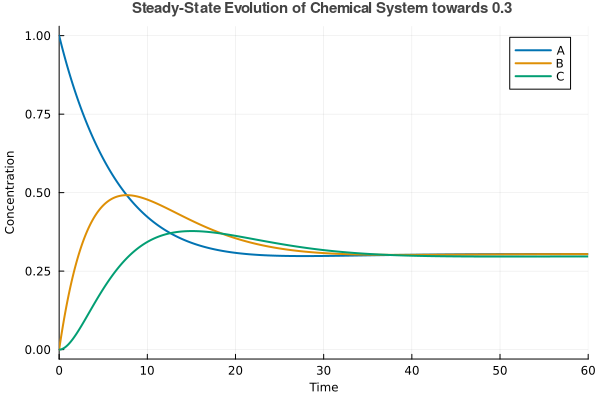

In [2]:
function chemsys!(du, u, p, t)
    A, B, C = u
    p1, k1, k2, c1 = p
    du[1] = ((p1)./(1 .+C)) .- k1.*A
    du[2] = k1.*A .- k2.*B
    du[3] = (k2.*B)./(1 .+C) - c1.*C
end;

# parameters
u0 = [1., 0., 0.]
initial_p = [0.075, 0.19, 0.19, 0.15]
tspan = (0., 60.)

# and create an ode problem to solve
problem = ODEProblem(chemsys!, u0, tspan, initial_p);
ground_truth_solution = DifferentialEquations.solve(problem)
plot(ground_truth_solution, linewidth=2, labels=["A" "B" "C"], xlabel="Time", ylabel="Concentration", 
labelfontsize=8, title="Steady-State Evolution of Chemical System towards 0.3", 
titlefontsize = 10, titlefontfamily = "Helvetica Bold", palette=:seaborn_colorblind)

We then generate data using the same method as in the previous notebook.

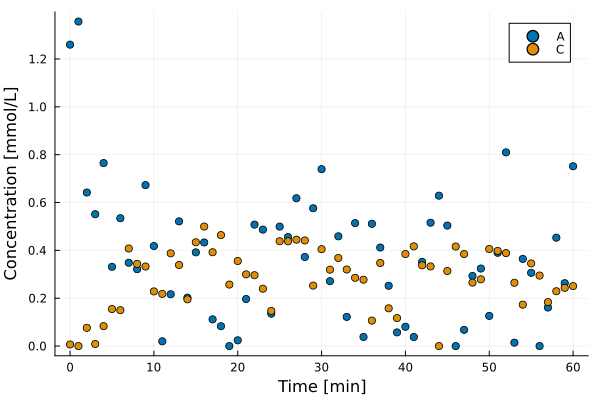

In [3]:
rng = MersenneTwister(313)
data_AC = max.(Matrix(ground_truth_solution(0:60, idxs=[1, 3])) .+ randn(rng, (2,61)).*[0.2, 0.12], 0)
scatter(0:60, data_AC', labels=["A" "C"], xlabel="Time [min]", ylabel = "Concentration [mmol/L]", palette=:seaborn_colorblind)

Finally, we perform the first round of parameter estimation and plot the resulting ODE system with estimated parameters. Again, we see proper fits for A and C, while for B the original model was not recovered correctly. 

The initial loss is 6.948032912084348
The final loss is 3.557713906147179


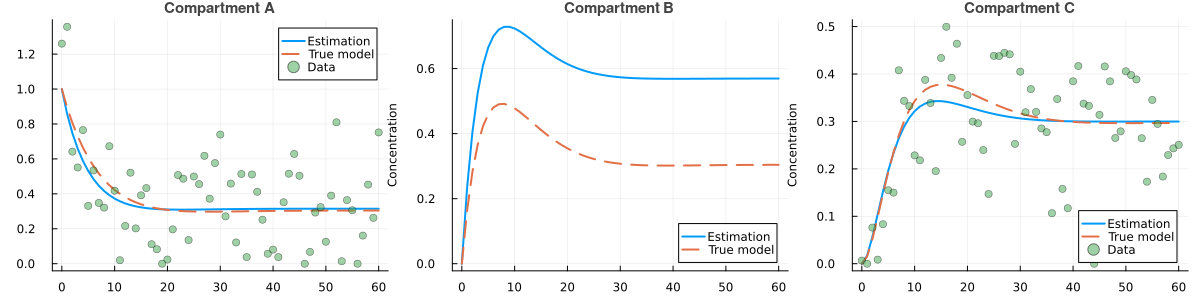

In [4]:
# initial parameters for parameter estimation
initial_p = [0.1, 0.15, 0.07, 0.12]

# define loss
function get_loss(data, problem::ODEProblem)

    loss = (p) -> begin
    # save the solution at every data point
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:60)

    error = sum(abs2, Matrix(solution)[[1,3],:].-data)
    return error, solution
    end

    loss
end

loss_func = get_loss(data_AC, problem)

println("The initial loss is $(loss_func(initial_p)[1])")

# estimate parameters
adtype = Optimization.AutoZygote()
optf   = Optimization.OptimizationFunction((x,p) -> loss_func(x), adtype);

opt_problem = Optimization.OptimizationProblem(optf, initial_p, lb = [0.,0.,0.,0.], ub=[0.5,0.5,0.5,0.5]);
sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)),x_tol=1e-12, g_tol=1e-12)

assimilated_system = remake(problem, p = sol.u, tspan=(0.,60.))
assimilated_ode_solution = DifferentialEquations.solve(assimilated_system)

println("The final loss is $(loss_func(sol.u)[1])")


# plot results
# A
pA = plot(assimilated_ode_solution(0:60, idxs=1), labels="Estimation", title="Compartment A")
plot!(pA, ground_truth_solution(0:60, idxs=1), labels="True model", ls=:dash)
scatter!(pA, 0:60, data_AC'[:,1], labels="Data", alpha=0.5)

# B
pB = plot(assimilated_ode_solution(0:60, idxs=2), labels="Estimation", title="Compartment B")
plot!(pB, ground_truth_solution(0:60, idxs=2), labels="True model", ls=:dash)

# C
pC = plot(assimilated_ode_solution(0:60, idxs=3), labels="Estimation", title="Compartment C")
plot!(pC, ground_truth_solution(0:60, idxs=3), labels="True model", ls=:dash)
scatter!(pC, 0:60, data_AC'[:,2], labels="Data", alpha=0.5)

plot(pA, pB, pC, linewidth=2, xlabel="Time", ylabel="Concentration", 
labelfontsize=8, titlefontsize = 10, titlefontfamily = "Helvetica Bold", layout=(1,3), size=(1200,300), palette=:seaborn_colorblind)

To start the parameter identifiability analysis, we create a PLAProblem, similarly to solving ODEs or estimating parameters. The PLA problem requires a loss function as input which has two arguments, but our loss function only has one, which is why we create an anonymous function where the second argument is not used. The second argument of the PLA problem is the set of estimated parameters.

In [5]:
pla_problem = PLAProblem((x,p) -> loss_func(x), sol.u);

For each parameter, we collect a figure and the raw output of the PLA. During the computation, we also decide to print the found confidence intervals of the parameters, based on the set threshold, which is, by default, the 95th percentile of a chi-squared distribution.

In [6]:
pla_results = Any[]
raw_outputs = PLAResult[]
pnames = ["P1", "K1", "K2", "C1"]
for i in 1:4
    PLA_output = ProfileLikelihoodAnalysis.solve(pla_problem, i; lb = [0.,0.,0.], ub=[0.5,0.5,0.5], max_par=i==3 ? 2. : 1., sample_size=1000)
    println("$(pnames[i]): $(PLA_output.confint)")
    push!(pla_results, plot(PLA_output, title="$(pnames[i])", legend=i == 1, xlabel= (i == 3 || i ==4) ? "Parameter Value" : "", ylabel = (i == 1 || i ==3) ? "Objective" : ""))
    push!(raw_outputs, PLA_output)
end

P1: (0.028230800027358484, 0.28513739697060186)
K1: (0.09454101217591265, 0.9419189416283664)
K2: (0.020186067586189797, Inf)
C1: (0.07062036206885687, 0.701238849647042)


For parameter K2, we find a confidence interval that is unbound on the upper side. Because of this, we suspect that is might be practically unidentifiable. To investigate this, we also plot the resulting curves.

In [2]:
plot(pla_results..., layout=4, size=(700,700), labelfontsize=8, legendposition=:topright, link=:y)

LoadError: UndefVarError: plot not defined

Observe that parameter K2 is not identifiable from the data we provided in this case. We can solve this by also adding in measurements for B, or fixing the parameter to a known value. Another way could be to add in a regularization term. In this case, say we know the steady state value of B to be 0.3, we can modify the loss function by including a regularization term, controlled by hyperparameter $\lambda$, penalizing on the last value of B. We also write a custom function to evaluate the contribution of both the regularization term and the data.

## Regularization

In [8]:
# define loss
function get_loss_regularized(data, problem::ODEProblem)

    loss = (p, λ) -> begin
    # save the solution at every data point
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:60)

    error_in_data = sum(abs2, Matrix(solution)[[1,3],:].-data)

    # regularization term
    regularization = (Matrix(solution)[2, 60] .- 0.3).^2

    error = error_in_data .+ λ.*regularization
    return error, solution
    end

    loss
end

function decomposed_loss(data, problem::ODEProblem, p, λ)

    # save the solution at every data point
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:60)

    error_in_data = sum(abs2, Matrix(solution)[[1,3],:].-data)

    # regularization term
    regularization = (Matrix(solution)[2, 60] .- 0.3).^2

    return error_in_data, regularization
end;

decomposed_loss (generic function with 1 method)

To evaluate the effect of $\lambda$, we can construct the pareto frontier of both error terms, by looping over a logarithmic range between $\exp(-5)$ and $\exp(5)$

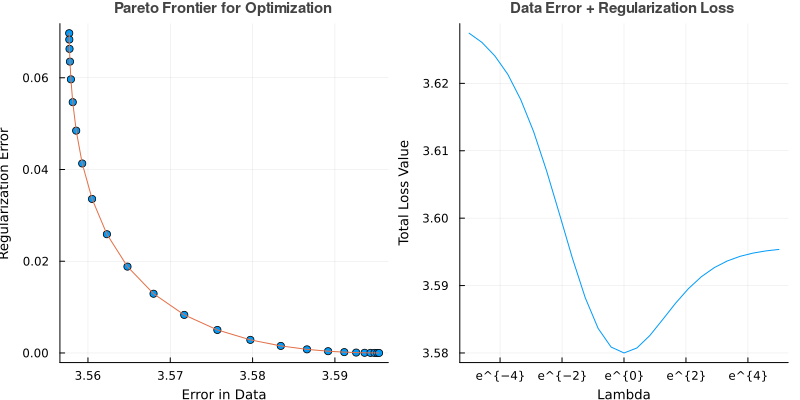

In [33]:
loss_func = get_loss_regularized(data_AC, problem)

data_error = Any[]
regularization_term = Any[]

for λ in exp.(LinRange(-5., 5., 25))

    #println("The initial loss is $(loss_func(initial_p, λ)[1])")

    # estimate parameters
    adtype = Optimization.AutoZygote()
    optf   = Optimization.OptimizationFunction(loss_func, adtype);

    opt_problem = Optimization.OptimizationProblem(optf, initial_p, λ, lb = [0.,0.,0.,0.], ub=[0.5,0.5,0.5,0.5]);
    sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)),x_tol=1e-12, g_tol=1e-12)

    assimilated_system = remake(problem, p = sol.u, tspan=(0.,60.))
    assimilated_ode_solution = DifferentialEquations.solve(assimilated_system)

    #println("The final loss is $(loss_func(sol.u, λ)[1])")
    ed, er = decomposed_loss(data_AC, problem, sol.u, λ)
    push!(data_error, ed)
    push!(regularization_term, er)
end

pareto = scatter(data_error, regularization_term, label="", title="Pareto Frontier for Optimization", xlabel="Error in Data", ylabel="Regularization Error", titlefontsize=10, labelfontsize=9, titlefontfamily="Helvetica Bold")
plot!(pareto, data_error, regularization_term, label="")

lambda_loss = plot(exp.(LinRange(-5., 5., 25)), data_error.+regularization_term, xaxis=:ln, labels="",title="Data Error + Regularization Loss", xlabel="Lambda", ylabel="Total Loss Value", titlefontsize=10, labelfontsize=9, titlefontfamily="Helvetica Bold")
plot(pareto, lambda_loss, layout=2, size=(800,400))

We observe a nice pareto frontier of optimal solutions. Moreover, we can see that the combined contribution of the data loss and the regularization term reaches a minimum at $\lambda$ = 1$. However, in the next example, we increase the $\lambda$ to show that regularization can change a practically unidentifiable parameter into an identifiable parameter. 

The initial loss is 12.070788902499235
The final loss is 3.5928845724008984


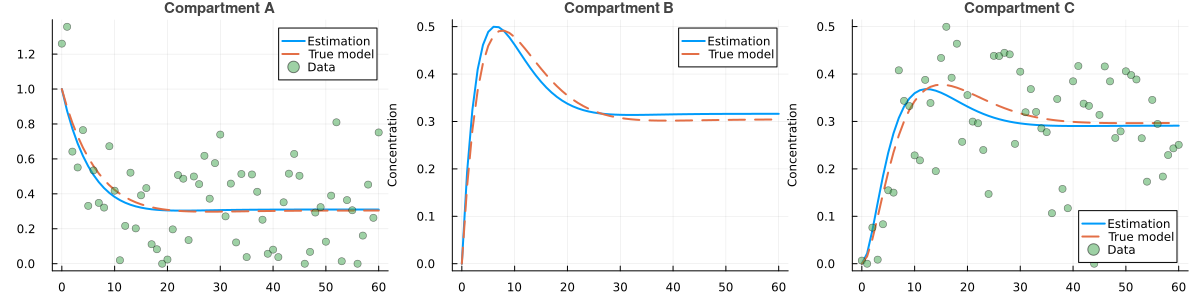

In [34]:
λ = 10.

println("The initial loss is $(loss_func(initial_p, λ)[1])")

# estimate parameters
adtype = Optimization.AutoZygote()
optf   = Optimization.OptimizationFunction(loss_func, adtype);

opt_problem = Optimization.OptimizationProblem(optf, initial_p, λ, lb = [0.,0.,0.,0.], ub=[0.5,0.5,0.5,0.5]);
sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)),x_tol=1e-12, g_tol=1e-12)

assimilated_system = remake(problem, p = sol.u, tspan=(0.,60.))
assimilated_ode_solution = DifferentialEquations.solve(assimilated_system)

println("The final loss is $(loss_func(sol.u, λ)[1])")

# plot results
# A
pA = plot(assimilated_ode_solution(0:60, idxs=1), labels="Estimation", title="Compartment A")
plot!(pA, ground_truth_solution(0:60, idxs=1), labels="True model", ls=:dash)
scatter!(pA, 0:60, data_AC'[:,1], labels="Data", alpha=0.5)

# B
pB = plot(assimilated_ode_solution(0:60, idxs=2), labels="Estimation", title="Compartment B")
plot!(pB, ground_truth_solution(0:60, idxs=2), labels="True model", ls=:dash)

# C
pC = plot(assimilated_ode_solution(0:60, idxs=3), labels="Estimation", title="Compartment C")
plot!(pC, ground_truth_solution(0:60, idxs=3), labels="True model", ls=:dash)
scatter!(pC, 0:60, data_AC'[:,2], labels="Data", alpha=0.5)

plot(pA, pB, pC, linewidth=2, xlabel="Time", ylabel="Concentration", 
labelfontsize=8, titlefontsize = 10, titlefontfamily = "Helvetica Bold", layout=(1,3), size=(1200,300), palette=:seaborn_colorblind)

We see that compartment B is fit more strongly to the true model. We can also inspect the effect of this regularization on the identifiability of the parameters.

In [35]:
pla_problem = PLAProblem(loss_func, sol.u);

pla_results = Any[]
raw_outputs = PLAResult[]
pnames = ["P1", "K1", "K2", "C1"]
for i in 1:4
    PLA_output = ProfileLikelihoodAnalysis.solve(pla_problem, i; lb = [0.,0.,0.], ub=[0.5,0.5,0.5], max_par=i==3 ? 2. : 1., sample_size=1000,hyperparameters=λ)
    println("$(pnames[i]): $(PLA_output.confint)")
    push!(pla_results, plot(PLA_output, title="$(pnames[i])", legend=i == 1, xlabel= (i == 3 || i ==4) ? "Parameter Value" : "", ylabel = (i == 1 || i ==3) ? "Objective" : ""))
    push!(raw_outputs, PLA_output)
end

P1: (0.03219800129707566, 0.2643522350555155)
K1: (0.10570437702157957, 0.660204532046349)
K2: (0.07724173188206304, 1.0725768266221505)
C1: (0.07404898933987042, 0.6524221364322129)


As can be seen, we now also have confidence bounds for $k2$. Plotting the profile likelihood curves also shows the threshold has been reached for all parameters. 

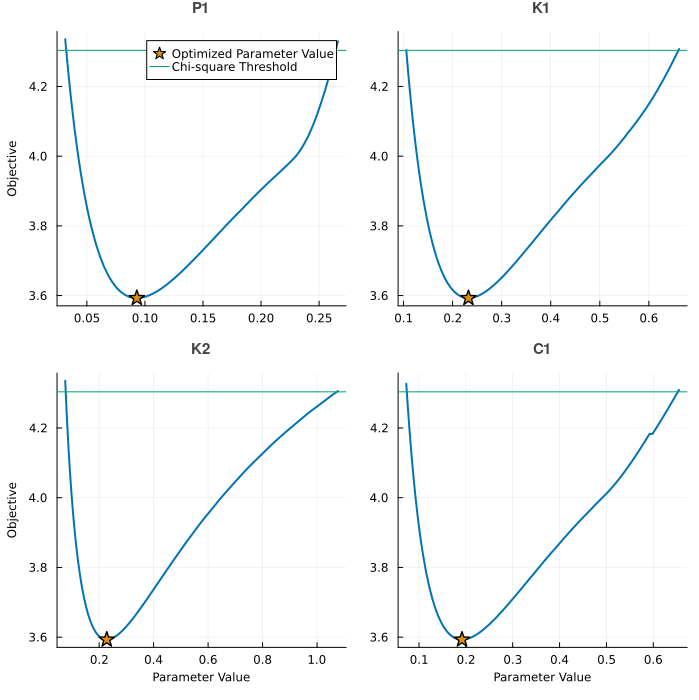

In [36]:
plot(pla_results..., layout=4, size=(700,700), labelfontsize=8, legendposition=:topright, link=:y)